In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from pyslabgrid import eqcatana as eqc

In [2]:
def get_mags(catalog, min_year=1900, min_mag=3.0, slabzone = 'hik-whole', decimate=None):
    #
    cat_folder = '../02midslab-config/projected_catalogs/'
    eqcat = eqc.read_projectedslabcatalog(cat_folder+catalog, min_year=min_year, min_mag=min_mag)
    slon = np.array(eqcat['slon'])
    slat = np.array(eqcat['slat'])
    smag = np.array(eqcat['mag'])

    in_zone = eqc.get_inpolgyon((eqcat['slon'],eqcat['slat']), eqc.get_zonepolygon(slabzone))
    mags_in_zone = smag[in_zone]
    if decimate is not None:
        mags_in_zone = [round(m, decimate) for m in mags_in_zone]
    return mags_in_zone

def calc_bvalue(M, binsize=0.1, Mmin=None, echo=False):
    # calculate b-value using the MLE method
    if Mmin is None:
        Mmin  = min(M)
    else:
        M = [m for m in M if m>=Mmin]
    if echo:
        if len(M)<25:
            print('*** number of events (<25) is rather scant')
    Mmean = np.mean(M)
    bvalue = (1/(Mmean-(Mmin-(binsize/2.0))))*np.log10(np.exp(1)); 
    return bvalue

def get_magbins(M, binsiz=0.1):
    #
    set_mag = [round(m,1) for m in np.arange(min(M), max(M)+binsiz, binsiz)]
    M = np.array(M)
    cumkount, kount, mag = [],[],[]
    for m in set_mag:
        k = sum(M==m)
        cumk = sum(M>=m)
        if k>0:
            kount.append(k)  
            cumkount.append(cumk)
            mag.append(m)
    return mag, kount, cumkount

def get_boot_grparams(slabzone, catalog, Mc=4.0, T=None):
    #
    catfile = catalog['file']
    cat_minyear = catalog['minyear']
    if T is None:
        nyears = 2020-cat_minyear
    else:
        nyears = T
        
    mags = get_mags(catfile, min_year=cat_minyear, \
                    slabzone = slabzone, decimate = 1)
    
    M = [m for m in mags if m>=Mc]
   
    bootfmd = {}
    bees, aaas = [], []
    
    for i in range(1000):
        btmag = np.random.choice(M, size=len(M), replace=True, p=None)
        # bootmag.append(btmag)

        b = calc_bvalue(btmag, Mmin=Mc)
        binmag, kount, cumkount = get_magbins(btmag)
        
        kount = [k/nyears for k in kount]
        cumkount = [k/nyears for k in cumkount]
    
        avals = [np.log10(n)+b*m for m,n in zip(binmag,cumkount)]
        bootfmd.update({i:(binmag, cumkount),})
        a = np.mean(avals)
        bees.append(b)
        aaas.append(a)
    
    bvalue =  calc_bvalue(mags, Mmin=Mc) 
    bvalue_std = np.std(bees)
    binmag, kount, cumkount = get_magbins(M)
    kount = [k/nyears for k in kount]
    cumkount = [k/nyears for k in cumkount]
    
    avals = [np.log10(n)+bvalue*m for m,n in zip(binmag,cumkount)]
    avalue = np.mean(avals)
    avalue_std = np.std(aaas)

    grparams  = {'bvalue':(bvalue, bvalue_std),
                 'avalue':(avalue, avalue_std),
                 'binmag': binmag, }
  
    return grparams, bootfmd


In [3]:
#
#import time
#start_time = time.time()
def plotfmd(ax, slabzone, zones):
    original_catalog = 'NZeqcat_Rollins13042020-subd-slab-proj2midslab.csv'
    #    declustered_catalog = 'Grue_NZeqcat_Rollins13042020SEPI-subd-slab-proj2midslab.csv'
    catalog = {'file': original_catalog, 'minyear': 1990}
   
    grparams, bootfmd = get_boot_grparams(slabzone, catalog, Mc=4.0, T=None)
    for k in bootfmd.keys():
        bmag, bcumkount = bootfmd[k]
        log10k = [np.log10(x) for x in bcumkount]
        ax.plot(bmag, log10k, 'o', markersize=6, color='c')

    bvalue, bvalue_std = grparams['bvalue']
    avalue, avalue_std = grparams['avalue']
    binmag = grparams['binmag']
    log10N = [(avalue - bvalue*m) for m in binmag]

    strlab = 'b=%.2f($\pm$%.2f)\na=%.2f($\pm$%.2f)' %(bvalue, bvalue_std, avalue, avalue_std)
    strlab = zones[slabzone] + '\n'+ strlab
    #ax.text(5, 1.65, zones[slabzone])
    ax.plot(binmag, log10N, '-', linewidth=3,color='brown', label = strlab);
    ax.legend(loc= 'upper right', frameon=False, fontsize=16)


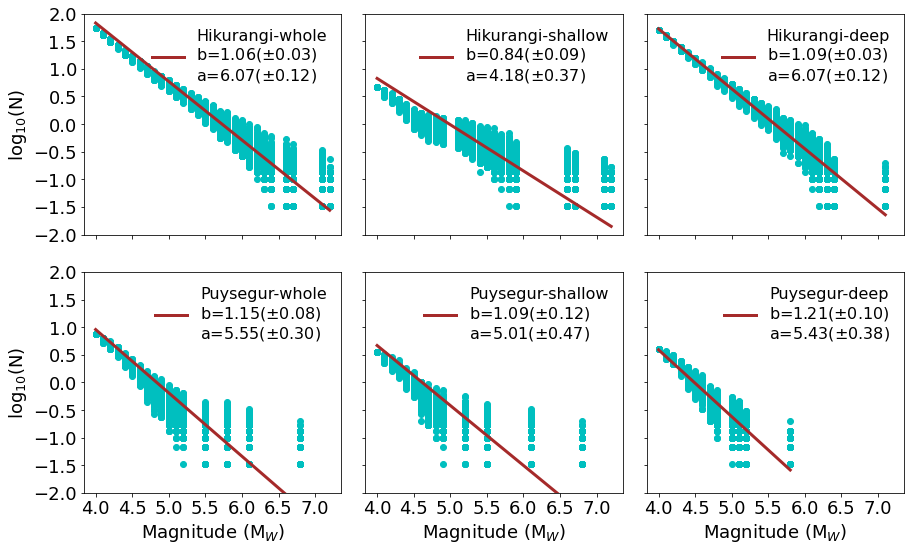

In [5]:
zones ={
    'hik-whole': 'Hikurangi-whole',
    'hik-flat': 'Hikurangi-shallow',
    'hik-steep': 'Hikurangi-deep',
    'puy-whole': 'Puysegur-whole',
    'puy-flat': 'Puysegur-shallow',
    'puy-steep': 'Puysegur-deep',}
    
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(2,3, figsize=(13,8), sharex=True, sharey=True)

slabzones = [z for z in zones.keys()]
1.7
plotfmd(ax[0, 0], slabzones[0], zones)
ax[0,0].set_ylabel('log$_{10}$(N)')

plotfmd(ax[0, 1], slabzones[1], zones)
plotfmd(ax[0, 2], slabzones[2], zones)

plotfmd(ax[1, 0], slabzones[3], zones)
ax[1,0].set_ylabel('log$_{10}$(N)')
ax[1,0].set_xlabel('Magnitude (M$_W$)')

plotfmd(ax[1, 1], slabzones[4], zones)
ax[1,1].set_xlabel('Magnitude (M$_W$)')

plotfmd(ax[1, 2], slabzones[5], zones)
ax[1,2].set_xlabel('Magnitude (M$_W$)')
ax[1,2].set_ylim([-1.8,2])
ax[1,2].set_xticks([x for x in np.arange(4.0, 7.2, 0.5)])
ax[1,2].set_yticks([x for x in np.arange(-2.0, 2.5, 0.5)])
fig.tight_layout()

plt.savefig('Figure6.jpeg', dpi=300, facecolor='w');